0. Preparação do Ambiente e Carregamento dos Dados
Primeiro, vamos importar as bibliotecas e carregar os dados das novas URLs.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# URLs atualizadas
url_adv = "https://raw.githubusercontent.com/laerciosantos09/Senac-MachineLearning/refs/heads/main/Atividade%203/Advertising.csv"
url_port = "https://raw.githubusercontent.com/laerciosantos09/Senac-MachineLearning/refs/heads/main/Atividade%203/Portland_housePrices.csv"

# Carregando os datasets
dados_adv = pd.read_csv(url_adv, index_col=0)
dados_por = pd.read_csv(url_port) # O dataset Portland às vezes não tem index_col, ajustamos se necessário

print("Advertising Head:")
display(dados_adv.head())
print("\nPortland Head:")
display(dados_por.head())

Advertising Head:


,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9



Portland Head:


,tamanho,quartos,preco
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


Exercício 1
Objetivo: Testar a estabilidade do fit e comparar implementações (OLS vs SGD).

Vamos focar no dataset Portland_housePrices para este exemplo simples (Tamanho -> Preço).

In [3]:
# Preparação dos dados (Portland)
X = dados_por[['tamanho']]
y = dados_por['preco']

# 1. Teste de estabilidade com LinearRegression (Mínimos Quadrados)
print("--- LinearRegression (OLS) ---")
for i in range(3):
    reg = LinearRegression().fit(X, y)
    print(f"Execução {i+1}: Coeficiente: {reg.coef_[0]:.4f}, Intercepto: {reg.intercept_:.4f}")

# 2. Teste de estabilidade com SGDRegressor (Descida de Gradiente)
# IMPORTANTE: SGD exige dados normalizados para funcionar bem
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n--- SGDRegressor (Gradiente) ---")
for i in range(3):
    # random_state=None garante que a inicialização seja aleatória a cada vez
    reg_sgd = SGDRegressor(max_iter=5000, tol=1e-3, eta0=0.01, random_state=None)
    reg_sgd.fit(X_scaled, y)
    print(f"Execução {i+1}: Coeficiente: {reg_sgd.coef_[0]:.4f}, Intercepto: {reg_sgd.intercept_[0]:.4f}")

--- LinearRegression (OLS) ---
Execução 1: Coeficiente: 134.5253, Intercepto: 71270.4924
Execução 2: Coeficiente: 134.5253, Intercepto: 71270.4924
Execução 3: Coeficiente: 134.5253, Intercepto: 71270.4924

--- SGDRegressor (Gradiente) ---
Execução 1: Coeficiente: 105737.6567, Intercepto: 340425.6946
Execução 2: Coeficiente: 105606.9139, Intercepto: 340109.2348
Execução 3: Coeficiente: 105696.4816, Intercepto: 340318.8056


Exercício 2

Objetivo: Regressão Multivariada, métricas e performance. Usaremos o dataset Advertising (TV, Radio, Newspaper -> Sales).

In [4]:
# Preparação (Advertising)
X_adv = dados_adv[['TV', 'radio', 'newspaper']]
y_adv = dados_adv['sales']

# 1. Treinar modelo com todos os atributos
reg_multi = LinearRegression().fit(X_adv, y_adv)
y_pred = reg_multi.predict(X_adv)

# Métricas
rss = np.sum((y_adv - y_pred) ** 2)
r2 = r2_score(y_adv, y_pred)

print(f"Modelo Multivariado (TV, Radio, Newspaper):")
print(f"RSS: {rss:.2f}")
print(f"R^2: {r2:.4f}")

# Comparação rápida com univariado (só TV, por exemplo)
reg_tv = LinearRegression().fit(dados_adv[['TV']], y_adv)
print(f"R^2 (Apenas TV): {r2_score(y_adv, reg_tv.predict(dados_adv[['TV']])):.4f}")

# 3. Teste de Velocidade
print("\n--- Teste de Velocidade ---")
# LinearRegression
start = time.time()
LinearRegression().fit(X_adv, y_adv)
end = time.time()
print(f"Tempo LinearRegression (OLS): {end - start:.6f} segundos")

# SGDRegressor (com dados normalizados)
scaler_adv = StandardScaler()
X_adv_scaled = scaler_adv.fit_transform(X_adv)
start = time.time()
SGDRegressor(max_iter=5000).fit(X_adv_scaled, y_adv)
end = time.time()
print(f"Tempo SGDRegressor: {end - start:.6f} segundos")

Modelo Multivariado (TV, Radio, Newspaper):
RSS: 556.83
R^2: 0.8972
R^2 (Apenas TV): 0.6119

--- Teste de Velocidade ---
Tempo LinearRegression (OLS): 0.002362 segundos
Tempo SGDRegressor: 0.002093 segundos


Exercício 3

Objetivo: Análise de Resíduos e Valor P (Significância Estatística).

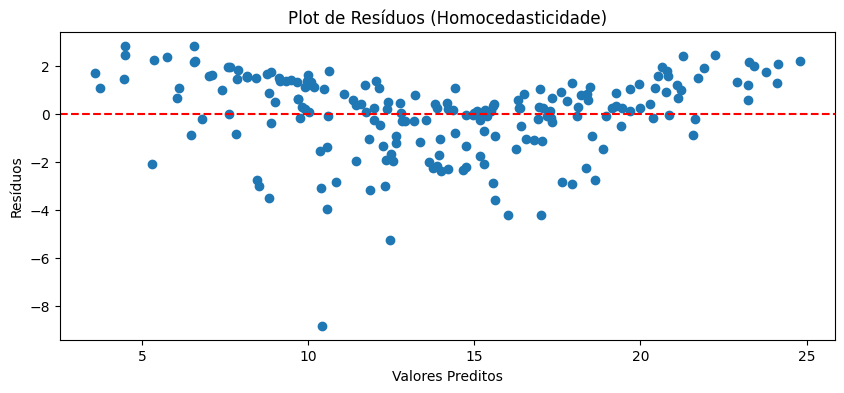

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           1.58e-96
Time:                        03:56:30   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

In [5]:
# 1. Plot de Resíduos
residuos = y_adv - y_pred

plt.figure(figsize=(10, 4))
plt.scatter(y_pred, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Plot de Resíduos (Homocedasticidade)')
plt.show()

# 2. Calcular Valores P usando statsmodels (Padrão de mercado)
X_sm = sm.add_constant(X_adv) # Adiciona constante para o intercepto
modelo_sm = sm.OLS(y_adv, X_sm).fit()
print(modelo_sm.summary())

# Comparação: Removendo a variável com P-valor alto (provavelmente Newspaper)
X_new = dados_adv[['TV', 'radio']] # Removemos newspaper
reg_new = LinearRegression().fit(X_new, y_adv)
print(f"\nR^2 sem Newspaper: {r2_score(y_adv, reg_new.predict(X_new)):.4f}")
print(f"R^2 com Newspaper: {r2:.4f}")

Exercício 4 (Extra)

Objetivo: Multicolinearidade (VIF).

A multicolinearidade ocorre quando duas variáveis independentes são muito correlacionadas entre si, atrapalhando o modelo de estimar o efeito individual de cada uma.

In [6]:
# Cálculo do VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_adv.columns

# O VIF é calculado para cada feature
vif_data["VIF"] = [variance_inflation_factor(X_adv.values, i)
                          for i in range(len(X_adv.columns))]

print(vif_data)

     feature       VIF
0         TV  2.486772
1      radio  3.285462
2  newspaper  3.055245
